In [ ]:
# GPU BEGONE!
import os
os.environ['LD_LIBRARY_PATH'] = '/usr/lib/x86_64-linux-gnu:/usr/lib/x86_64-linux-gnu'
os.environ['PATH'] = '/home/fandav/.local/bin:/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/opt/anaconda3/envs/jupyter/bin:/opt/anaconda3/bin/:/snap/bin'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ

In [2]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
import numpy as np
import pandas as pd

# To find out which devices your operations and tensors are assigned to
#tf.debugging.set_log_device_placement(True)

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

# Obtain Embeddings

In [3]:
# tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased');

# model
model = TFBertModel.from_pretrained('bert-base-uncased');
model.summary()

Model: "tf_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
Total params: 109,482,240
Trainable params: 109,482,240
Non-trainable params: 0
_________________________________________________________________


# Import Data

In [4]:
dataset = pd.read_csv('final_dataset.csv', index_col=0)
#display(dataset.loc['Content'].values)

In [5]:
# grab content
dataset_content = dataset.loc['Content'].fillna('').values
#print(dataset_content)

# process content through BERT
encoded_strings = [tokenizer.encode(content, max_length=512, pad_to_max_length=True) for content in dataset_content]
encoded_vectors = tf.constant(encoded_strings)
outputs = model(encoded_vectors)

# obtain per line embeddings from all the artibles from BERT
last_hidden_states = outputs[0]

# obtain article embeddings from BERT
article_embeddings = outputs[1]

print(np.shape(outputs))
print(np.shape(outputs[0]))
print(np.shape(outputs[1]))

(2, 50)
(50, 512, 768)
(50, 768)


In [6]:
_, num_articles = np.shape(outputs)
article_names = [f'Article {idx}' for idx in range(num_articles)]

# vector embeddings of each article
vec_embeddings = article_embeddings.numpy()

In [7]:
# final classifier labels
credibility_label = np.array(list(map(int, dataset.loc['Credibility Score'].values)))

# run NN with last layers changed to fit labels for each indicator
indicators = [
              'Originality Score',
              'Fact-Checked',
              'Attribution Rank',
              'Source 1 Category',
              'Source 2 Category',
              'Source 3 Category',
              'Article has Spammy/Clickbaity Ads',
              'Article has Aggressive Ads/Calls'
             ]

indicator_data = []
for truth_label in indicators:
    label_values = np.array(np.array(list(map(int, dataset.loc[truth_label].values))))
    indicator_data.append([label_values, len(label_values), set(label_values), len(set(label_values))])

In [8]:
indicators_df = pd.DataFrame(indicator_data,
                             columns=['truth label values', 'number of truth label values', 'unique truth labels', 'size of unique truth labels'],
                             index=indicators
                            )
display(indicators_df)

,truth label values,number of truth label values,unique truth labels,size of unique truth labels
Originality Score,"[0, 2, 0, 1, 3, 1, 0, 2, 0, 2, 2, 3, 0, 1, 2, ...",50,"{0, 1, 2, 3}",4
Fact-Checked,"[1, 2, 4, 1, 2, 1, 1, 2, 3, 1, 2, 1, 1, 1, 3, ...",50,"{0, 1, 2, 3, 4}",5
Attribution Rank,"[1, 2, 0, 1, 3, 1, 0, 2, 0, 2, 2, 3, 0, 4, 3, ...",50,"{0, 1, 2, 3, 4}",5
Source 1 Category,"[0, 2, 2, 0, 1, 3, 2, 2, 2, 0, 2, 2, 0, 3, 2, ...",50,"{0, 1, 2, 3}",4
Source 2 Category,"[0, 1, 0, 0, 1, 3, 3, 2, 3, 0, 1, 2, 0, 3, 0, ...",50,"{0, 1, 2, 3}",4
Source 3 Category,"[0, 1, 1, 0, 1, 3, 1, 2, 3, 0, 2, 2, 0, 3, 0, ...",50,"{0, 1, 2, 3}",4
Article has Spammy/Clickbaity Ads,"[2, 3, 1, 3, 2, 4, 4, 3, 4, 4, 2, 1, 2, 4, 3, ...",50,"{0, 1, 2, 3, 4, 5}",6
Article has Aggressive Ads/Calls,"[3, 3, 2, 4, 2, 3, 4, 4, 3, 4, 2, 1, 2, 4, 2, ...",50,"{0, 1, 2, 3, 4, 5}",6


In [9]:
numeric_indicator_labels = [
    'Number of Content Recommendations',
    'Number of Social Share Calls',
    'Number Calls to Join Mailing List',
    'Number of Ads',
    'Number of Sponsored Content',
]

numeric_indicator_data = []
for truth_label in numeric_indicator_labels:
    label_values = np.array(np.array(list(map(int, dataset.loc[truth_label].values))))
    numeric_indicator_data.append([label_values])

# compact data into 2D array to use for later
numeric_indicators = np.squeeze(numeric_indicator_data).T

In [10]:
# show data
numeric_indicator_df = pd.DataFrame(numeric_indicator_data,
                             columns=['truth label values'],
                             index=numeric_indicator_labels
                            )
display(numeric_indicator_df)

,truth label values
Number of Content Recommendations,"[1, 1, 0, 1, 1, 3, 8, 2, 3, 3, 2, 1, 2, 4, 5, ..."
Number of Social Share Calls,"[2, 9, 10, 24, 10, 5, 14, 5, 3, 6, 4, 14, 2, 1..."
Number Calls to Join Mailing List,"[0, 0, 0, 0, 1, 3, 0, 1, 0, 1, 0, 0, 0, 3, 0, ..."
Number of Ads,"[3, 0, 0, 9, 0, 1, 23, 0, 0, 4, 2, 2, 4, 0, 0,..."
Number of Sponsored Content,"[0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, ..."


In [11]:
display(dataset)

,Article 43,Article 13,Article 14,Article 30,Article 23,Article 42,Article 49,Article 36,Article 45,Article 7,...,Article 44,Article 46,Article 35,Article 38,Article 37,Article 28,Article 29,Article 39,Article 41,Article 12
Title,Which Banana Would You Eat? Your Answer May Ha...,NOW IT’S OFFICIAL: FDA Announced That Vaccines...,CONFIRMED: E-CIGARETTES CAUSE A HORRIBLE INCUR...,WITH ONLY 2 CUPS A DAY FOR 1 WEEK YOUR STOMACH...,"Lead Developer of HPV Vaccines Comes Clean, Wa...",DELINGPOLE: Global Warming Study Cancelled Bec...,Diet drinks TRIPLE your risk of stroke and dem...,NaN,NaN,Nations Press: PLS SHARE: DO NOT EAT THIS FISH...,...,NaN,Opinion | How the Anti-Vaxxers Are Winning,Arctic’s Winter Sea Ice Drops to Its Lowest Re...,The Best Exercise for Aging Muscles,An Iceberg the Size of Delaware Just Broke Awa...,Putting Kids To Bed Early Improves Mom's Healt...,If Everyone Ate Beans Instead of Beef,Arctic stronghold of world’s seeds flooded aft...,"The oldest child is actually the smartest, stu...",Coconut oil isn't healthy. It's never been hea...
Content,"When we eat bananas, we do so because we are h...",The FDA has published conclusive proof on thei...,CONFIRMED: E-CIGARETTES CAUSE A HORRIBLE INCUR...,The desire of lots of people is to have a flat...,"Lead Developer of HPV Vaccines Comes Clean, Wa...",A global warming research study in Canada has ...,"The Boston University study of almost 4,400 ad...",NaN,NaN,NaN,...,NaN,A major measles outbreak in America is only a ...,Much of the ice also appears to be thinner tha...,Certain kinds of exercise may mitigate the eff...,A crack more than 120 miles long had developed...,A new study confirms why all those bedtime bat...,"With one dietary change, the U.S. could hypoth...",No seeds were lost but the ability of the rock...,"Birth order doesn't affect personality, but it...","“We advise against the use of coconut oil,"" th..."
URL,http://goodfullness.net/which-banana-would-you...,http://inshapetoday.com/now-official-fda-annou...,http://nowcheckthis.com/2017/03/23/confirmed-e...,http://publichealthabc.com/2-cups-day-1-week-s...,http://www.alternativenewsnetwork.net/lead-dev...,http://www.breitbart.com/big-government/2017/0...,http://www.dailymail.co.uk/~/article-4429790/i...,http://www.iflscience.com/environment/heavy-mo...,http://www.iflscience.com/health-and-medicine/...,http://www.nationspressph.com/2017/02/pls-shar...,...,https://www.ntd.tv/inspiring/parenting/sam-ber...,https://www.nytimes.com/2017/02/08/opinion/how...,https://www.nytimes.com/2017/03/22/climate/arc...,https://www.nytimes.com/2017/03/23/well/move/t...,https://www.nytimes.com/interactive/2017/06/09...,https://www.simplemost.com/new-study-says-putt...,https://www.theatlantic.com/health/archive/201...,https://www.theguardian.com/environment/2017/m...,https://www.today.com/health/birth-order-first...,https://www.usatoday.com/story/news/nation-now...
Credibility Score,0,0,0,0,0,1,0,0,0,0,...,1,2,2,2,2,1,2,2,2,2
Originality Score,0,2,0,1,3,1,0,2,0,2,...,2,0,0,0,0,0,0,0,0,0
Attribution Rank,1,2,0,1,3,1,0,2,0,2,...,3,0,0,0,0,0,0,0,0,0
Fact-Checked,1,2,4,1,2,1,1,2,3,1,...,1,0,4,1,2,3,1,3,1,3
Source 1 Category,0,2,2,0,1,3,2,2,2,0,...,3,2,2,2,3,2,3,3,2,2
Source 2 Category,0,1,0,0,1,3,3,2,3,0,...,3,3,2,1,2,2,2,2,2,2
Source 3 Category,0,1,1,0,1,3,1,2,3,0,...,3,1,0,0,1,2,2,2,1,3


# Define Neural Network Model

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalMaxPooling1D, Conv1D, MaxPooling1D, InputLayer, Input, Softmax

# use LDA for last classifier on combined features
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [13]:
def model_def(last_layer_size):
    model = Sequential([
        Input(shape=(768, 1), name='input'),
        
        Conv1D(400, 3, padding='valid', activation='relu', strides=3, input_shape=(768,)),
        Dense(200, activation='relu', name='dense_0'),
        Dropout(0.2),
        
        #Conv1D(200, 3, padding='valid', activation='relu', strides=3),
        #Dense(150, activation='relu', name='dense_1'),
        #Dropout(0.2),
        
        Conv1D(100, 3, padding='valid', activation='relu', strides=5),
        GlobalMaxPooling1D(),
        
        Dense(64, activation='relu', name='dense_2'),
        
        #Dense(len(set(truth_labels)), name='dense_3', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        Dense(last_layer_size, name='dense_3', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        Softmax()
    ]);
    #model.summary()

    model.compile(optimizer=tf.keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  #loss=tf.keras.losses.SquaredHinge(),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['accuracy']);
    return model

In [14]:
def train_model(model, x, y, epochs=300, batch_size=10, verbose=1):
    model.fit(x, y, batch_size=batch_size, epochs=epochs, verbose=verbose)
    return model

def test_model(model, x, y, verbose=1):
    test_loss, test_acc = model.evaluate(x,  y, verbose=verbose)
    return test_loss, test_acc

def predict(model, x):
    # predict a few samples
    output = model.predict(x)
    print(f'Output Vector: \n{output}')
    print(f'Output Vector Rounded: \n{np.round(output)}')
    print('Output Label: {}'.format([np.where(r==1)[0][0] for r in np.round(output)]))
    return output

In [15]:
class EndingLossAccCallback(tf.keras.callbacks.Callback):

    def on_train_batch_end(self, batch, logs=None):
        print('Training: batch {}, Loss: {:.2f}, Accuracy: {:.2f}'.format(batch,  logs['loss'], logs['accuracy']))

    def on_test_batch_end(self, batch, logs=None):
        print('Testing: batch {}, Loss: {:.2f}, Accuracy: {:.2f}'.format(batch,  logs['loss'], logs['accuracy']))

In [98]:
# sample test run
n_epochs = 300

train_index = np.arange(1, 50)
test_index = np.arange(1)

# input embeddings are the same for each indicator
X_train = vec_embeddings[train_index]
X_test = vec_embeddings[test_index]

# expand input to fit input layer
X_train = np.expand_dims(X_train, 2)
X_test = np.expand_dims(X_test, 2)
print(np.shape(X_train))

# there's probably a better way to do this -_-
indicator_models = {}
indicator_Y_train = {}
indicator_Y_test = {}

# generate a neural network model for each indicator
for indicator in indicators:
    output_layer_length = indicators_df.loc[indicator]['size of unique truth labels']
    truth_labels = indicators_df.loc[indicator]['truth label values']
    
    # output labels are based on indicator
    Y_train = truth_labels[train_index]
    Y_test = truth_labels[test_index]

    # define model for indicator
    model = model_def(output_layer_length)
    #model.summary()
    
    # store handle to model and data as dict
    indicator_models[indicator] = model
    indicator_Y_train[indicator] = Y_train
    indicator_Y_test[indicator] = Y_test

# TRAIN ALLL THE MODELS!!!
for indicator in indicators:
    model = indicator_models[indicator]
    Y_train = indicator_Y_train[indicator]
    history = model.fit(X_train, Y_train,
                        batch_size=10,
                        epochs=n_epochs, verbose=0,)
                        #callbacks=[EndingLossAccCallback()])

(49, 768, 1)


In [257]:
X_train_numeric_indicator_features = numeric_indicators[train_index]
Y_train_cred_labels = credibility_label[train_index]

classifier_input_vec = []

# run inference on training data to generate outputs
for indicator in indicators:
    model = indicator_models[indicator]
    output = np.round(model.predict(X_train))
    num_output = [np.where(v==1)[0] for v in output]    
    classifier_input_vec.append([-1 if sum(vec) == 0 else np.argmax(vec) for vec in output])

# structure outputs and append on numerical indicator features (8-dim features + 5-dim features -> 13-dim features total)
classifier_input_vec = np.array(classifier_input_vec).T
combined_X_train_features = np.hstack((classifier_input_vec, X_train_numeric_indicator_features))

print(np.shape(combined_X_train_features))

(49, 13)


In [258]:
X_test_numeric_indicator_features = numeric_indicators[test_index]
Y_test_cred_labels = credibility_label[test_index]

classifier_input_vec = []

# run inference on training data to generate outputs
for indicator in indicators:
    model = indicator_models[indicator]
    output = np.round(model.predict(X_test))
    num_output = [np.where(v==1)[0] for v in output]    
    classifier_input_vec.append([-1 if sum(vec) == 0 else np.argmax(vec) for vec in output])

# structure outputs and append on numerical indicator features (8-dim features + 5-dim features -> 13-dim features total)
classifier_input_vec = np.array(classifier_input_vec).T
combined_X_test_features = np.hstack((classifier_input_vec, X_test_numeric_indicator_features))

print(np.shape(combined_X_test_features))

(1, 13)


In [261]:
# train classifier
clf = LinearDiscriminantAnalysis()
clf.fit(combined_X_train_features, Y_train_cred_labels)

##############################################
# test on training data
train_predictions = clf.predict(combined_X_train_features)

# compute accuracy
train_correctly_labeled = sum(Y_train_cred_labels == train_predictions)
train_total_predictions = len(Y_train_cred_labels)
train_accuracy = train_correctly_labeled / train_total_predictions
print(f'Train Accuracy: {train_accuracy}')

##############################################
# test on testing data
test_predictions = clf.predict(combined_X_test_features)

# compute accuracy
test_correctly_labeled = sum(Y_test_cred_labels == test_predictions)
test_total_predictions = len(Y_test_cred_labels)
test_accuracy = test_correctly_labeled / test_total_predictions
print(f'Test Accuracy: {test_accuracy}')

Train Accuracy: 0.7551020408163265
Test Accuracy: 0.0


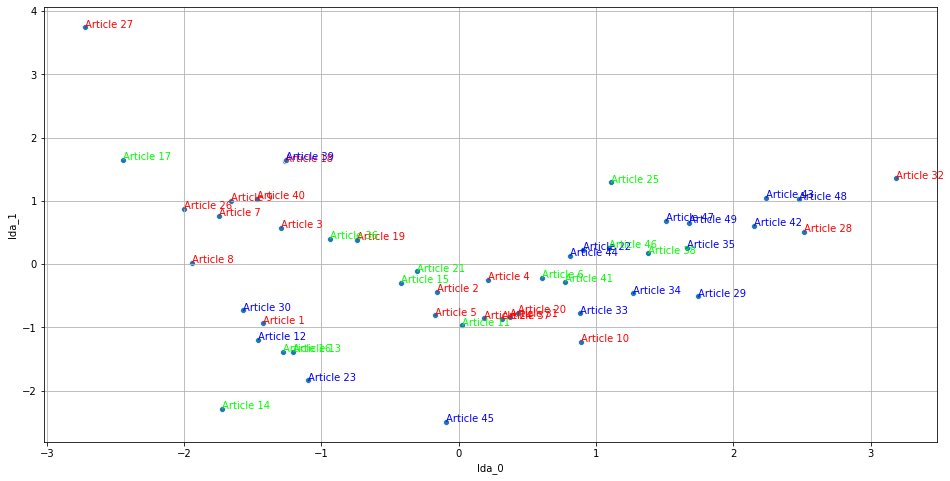

In [246]:
o = clf.transform(combined_features)
lda_df = pd.DataFrame(o, columns=['lda_0', 'lda_1'], index=np.array(article_names)[train_index])

plt.figure(figsize=(16,8))
sns.scatterplot(
    x='lda_0', y='lda_1',
    data=lda_df,
    legend='full'
)
plt.grid()
ax = plt.gca()
color = [[1,0,0], [0,1,0], [0,0,1]] # RGB
token_color = [color[credibility_label[_]] for _ in range(num_articles)]
for (k, v), color in zip(lda_df.iterrows(), token_color):
    ax.annotate(k, v, c=color)

In [26]:
from sklearn.model_selection import KFold

n_folds = 50
n_epochs = 400

# record classified results
results_truth = []
results_predictions = []

# hold accuracy for each indicator per fold
indicator_test_accuracy = {}
for indicator in indicators:
    indicator_test_accuracy[indicator] = []

kf = KFold(n_splits=n_folds)
kf.get_n_splits(vec_embeddings)
for k_index, (train_index, test_index) in enumerate(kf.split(vec_embeddings)):
    # input embeddings are the same for each indicator
    X_train = vec_embeddings[train_index]
    X_test = vec_embeddings[test_index]

    # expand input to fit input layer
    X_train = np.expand_dims(X_train, 2)
    X_test = np.expand_dims(X_test, 2)
    #print(np.shape(X_train))

    # there's probably a better way to do this -_-
    indicator_models = {}
    indicator_Y_train = {}
    indicator_Y_test = {}
    indicator_accuracy = {}

    # generate a neural network model for each indicator
    for indicator in indicators:
        output_layer_length = indicators_df.loc[indicator]['size of unique truth labels']
        truth_labels = indicators_df.loc[indicator]['truth label values']

        # output labels are based on indicator
        Y_train = truth_labels[train_index]
        Y_test = truth_labels[test_index]

        # define model for indicator
        model = model_def(output_layer_length)
        #model.summary()

        # store handle to model and data as dict
        indicator_models[indicator] = model
        indicator_Y_train[indicator] = Y_train
        indicator_Y_test[indicator] = Y_test

    # TRAIN ALLL THE MODELS!!!
    # this will probably take the longest
    for indicator in indicators:
        model = indicator_models[indicator]
        Y_train = indicator_Y_train[indicator]
        history = model.fit(X_train, Y_train,
                            batch_size=10,
                            epochs=n_epochs, verbose=0,)
                            #callbacks=[EndingLossAccCallback()])
    
    # TEST ALLL THE MODELS!!!
    for indicator in indicators:
        model = indicator_models[indicator]
        Y_test = indicator_Y_test[indicator]
        test_loss, test_acc = model.evaluate(X_test,  Y_test, verbose=0)
    
        # record accuracy on testing
        indicator_test_accuracy[indicator].append(test_acc)
    
    print('==================================')
    print(f'Running Fold Number {k_index}')
    print(f'Size of Training Set: {len(train_index)}')
    print(f'Size of Testing Set: {len(test_index)}: {test_index}')
    print('------------------------')
    #model.predict(X_test[0:1])
    
    # Combined features are outputs from each neural network 
    # plus the features from the scraper counting numeric instances (ie. Num Ads, Num Social Calls, etc.)
    
    ########################################
    # Build Training Combined Features
    ########################################
    X_train_numeric_indicator_features = numeric_indicators[train_index]
    Y_train_cred_labels = credibility_label[train_index]

    classifier_input_vec = []

    # run inference on training data to generate outputs
    for indicator in indicators:
        model = indicator_models[indicator]
        output = np.round(model.predict(X_train))
        num_output = [np.where(v==1)[0] for v in output]    
        classifier_input_vec.append([-1 if sum(vec) == 0 else np.argmax(vec) for vec in output])

    # structure outputs and append on numerical indicator features (8-dim features + 5-dim features -> 13-dim features total)
    classifier_input_vec = np.array(classifier_input_vec).T
    combined_X_train_features = np.hstack((classifier_input_vec, X_train_numeric_indicator_features))

    #print(np.shape(combined_X_train_features))
    
    ########################################
    # Build Testing Combined Features
    ########################################
    X_test_numeric_indicator_features = numeric_indicators[test_index]
    Y_test_cred_labels = credibility_label[test_index]

    classifier_input_vec = []

    # run inference on training data to generate outputs
    for indicator in indicators:
        model = indicator_models[indicator]
        output = np.round(model.predict(X_test))
        num_output = [np.where(v==1)[0] for v in output]    
        classifier_input_vec.append([-1 if sum(vec) == 0 else np.argmax(vec) for vec in output])

    # structure outputs and append on numerical indicator features (8-dim features + 5-dim features -> 13-dim features total)
    classifier_input_vec = np.array(classifier_input_vec).T
    combined_X_test_features = np.hstack((classifier_input_vec, X_test_numeric_indicator_features))

    #print(np.shape(combined_X_test_features))
    
    ########################################
    # Train LDA and Run on Testing Data
    ########################################
    # train classifier
    clf = LinearDiscriminantAnalysis()
    clf.fit(combined_X_train_features, Y_train_cred_labels)

    ##############################################
    # test on training data
    train_predictions = clf.predict(combined_X_train_features)

    # compute accuracy
    train_correctly_labeled = sum(Y_train_cred_labels == train_predictions)
    train_total_predictions = len(Y_train_cred_labels)
    classifier_train_accuracy = train_correctly_labeled / train_total_predictions
    print(f'Classifier Train Accuracy: {classifier_train_accuracy}')

    ##############################################
    # test on testing data
    test_predictions = clf.predict(combined_X_test_features)

    # compute accuracy
    test_correctly_labeled = sum(Y_test_cred_labels == test_predictions)
    test_total_predictions = len(Y_test_cred_labels)
    classifier_test_accuracy = test_correctly_labeled / test_total_predictions
    print(f'Classifier Test Accuracy: {classifier_test_accuracy}')
    
    # record prediction and truth labels
    results_truth.append(Y_test_cred_labels)
    results_predictions.append(test_predictions)

Running Fold Number 0
Size of Training Set: 49
Size of Testing Set: 1: [0]
------------------------
Classifier Train Accuracy: 0.7551020408163265
Classifier Test Accuracy: 0.0
Running Fold Number 1
Size of Training Set: 49
Size of Testing Set: 1: [1]
------------------------
Classifier Train Accuracy: 0.7346938775510204
Classifier Test Accuracy: 0.0
Running Fold Number 2
Size of Training Set: 49
Size of Testing Set: 1: [2]
------------------------
Classifier Train Accuracy: 0.7755102040816326
Classifier Test Accuracy: 0.0
Running Fold Number 3
Size of Training Set: 49
Size of Testing Set: 1: [3]
------------------------
Classifier Train Accuracy: 0.7551020408163265
Classifier Test Accuracy: 1.0
Running Fold Number 4
Size of Training Set: 49
Size of Testing Set: 1: [4]
------------------------
Classifier Train Accuracy: 0.7959183673469388
Classifier Test Accuracy: 1.0
Running Fold Number 5
Size of Training Set: 49
Size of Testing Set: 1: [5]
------------------------
Classifier Train Acc

### Compute average across folds

In [29]:
indicator_accuracy_per_fold_df = pd.DataFrame(indicator_test_accuracy, index=article_names)

# compute average for last row
average_indicator_accuracy_per_label = [np.mean(indicator_accuracy_per_fold_df[col].values) for col in indicator_accuracy_per_fold_df.columns]
indicator_accuracy_per_fold_df.loc['Average'] = average_indicator_accuracy_per_label

display(indicator_accuracy_per_fold_df)
indicator_accuracy_per_fold_df.to_csv('results/indicator_accuracy.csv')

,Originality Score,Fact-Checked,Attribution Rank,Source 1 Category,Source 2 Category,Source 3 Category,Article has Spammy/Clickbaity Ads,Article has Aggressive Ads/Calls
Article 0,1.00,1.00,0.0,0.0,0.00,0.00,1.00,0.00
Article 1,0.00,0.00,0.0,1.0,0.00,0.00,0.00,0.00
Article 2,1.00,0.00,1.0,1.0,0.00,1.00,1.00,0.00
Article 3,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00
Article 4,0.00,0.00,1.0,0.0,0.00,0.00,0.00,0.00
Article 5,0.00,1.00,0.0,0.0,0.00,0.00,0.00,0.00
Article 6,1.00,1.00,1.0,1.0,0.00,1.00,0.00,1.00
Article 7,1.00,0.00,0.0,1.0,0.00,0.00,0.00,0.00
Article 8,0.00,0.00,0.0,1.0,0.00,0.00,0.00,0.00
Article 9,1.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00


In [70]:
partial_indicator_accuracy = indicator_accuracy_per_fold_df.iloc[-11:]
display(partial_indicator_accuracy)
partial_indicator_accuracy.to_csv('results/partial_indicator_accuracy.csv')

,Originality Score,Fact-Checked,Attribution Rank,Source 1 Category,Source 2 Category,Source 3 Category,Article has Spammy/Clickbaity Ads,Article has Aggressive Ads/Calls
Article 40,1.00,0.00,0.0,0.0,1.00,0.00,0.00,0.00
Article 41,1.00,0.00,1.0,1.0,0.00,1.00,0.00,0.00
Article 42,1.00,0.00,1.0,1.0,1.00,0.00,0.00,0.00
Article 43,1.00,1.00,1.0,1.0,0.00,0.00,0.00,0.00
Article 44,1.00,1.00,1.0,0.0,1.00,0.00,0.00,0.00
Article 45,1.00,0.00,1.0,1.0,0.00,0.00,0.00,0.00
Article 46,1.00,1.00,1.0,0.0,0.00,0.00,0.00,1.00
Article 47,1.00,0.00,1.0,1.0,0.00,0.00,1.00,0.00
Article 48,1.00,1.00,1.0,1.0,1.00,0.00,0.00,0.00
Article 49,1.00,0.00,1.0,1.0,1.00,0.00,0.00,1.00


## Plot classified predictions and truth labels for each fold

In [35]:
final_results = {
    'results_truth': results_truth,
    'results_predictions': results_predictions
}
final_results_df = pd.DataFrame(final_results)
display(final_results_df)
final_results_df.to_csv('results/credibility_results.csv')

,results_truth,results_predictions
0,[0],[1]
1,[0],[1]
2,[0],[1]
3,[0],[0]
4,[0],[0]
5,[1],[0]
6,[0],[2]
7,[0],[0]
8,[0],[0]
9,[0],[0]


In [34]:
y_truth_value = [value[0] for value in final_results_df['results_truth'].values]
y_predictions = [value[0] for value in final_results_df['results_predictions'].values]

In [35]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_truth_value, y_predictions)#, labels=)
print(cm)

[[14  5  1]
 [ 5  4  4]
 [ 1  1 15]]


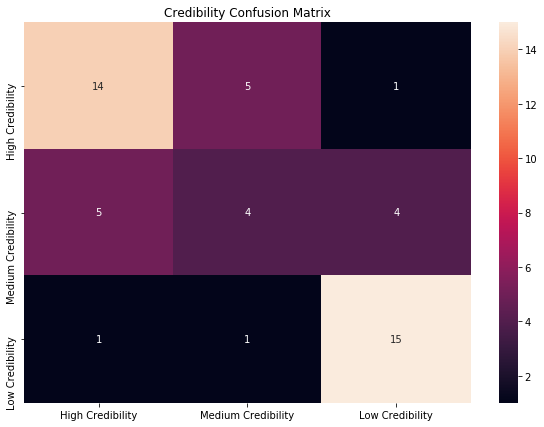

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

cm_df = pd.DataFrame(cm, index = [i for i in ['High Credibility', 'Medium Credibility', 'Low Credibility']],
                  columns = [i for i in ['High Credibility', 'Medium Credibility', 'Low Credibility']])
plt.figure(figsize = (10,7))
sns.heatmap(cm_df, annot=True)
plt.title('Credibility Confusion Matrix')
plt.savefig('graphics/confusion_matrix.png', bbox_inches='tight', pad_inches=0)

<ipython-input-55-e25800741040>:147: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
<ipython-input-55-e25800741040>:148: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
<ipython-input-55-e25800741040>:150: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
<ipython-input-55-e25800741040>:151: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
<ipython-input-55-e25800741040>:39: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  per_ok_s = ['%.2f%

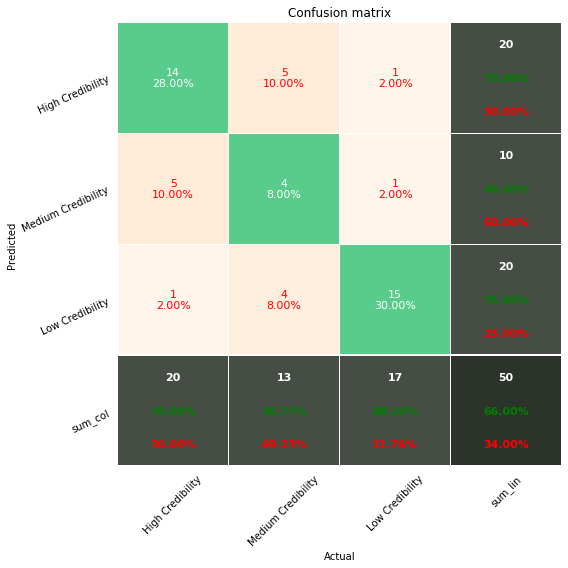

<Figure size 432x288 with 0 Axes>

In [56]:
from pretty_plot_confusion_matrix import pretty_plot_confusion_matrix
pretty_plot_confusion_matrix(cm_df)

#plt.savefig('graphics/prettier_confusion_matrix.png', bbox_inches='tight', pad_inches=0)